In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow.contrib.keras as kr
from sklearn import preprocessing
import logging
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import math
import pulp

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
matplotlib.rcParams.update({'font.size': 14})
def scale(num):
    scaler = MinMaxScaler()
    return scaler.fit_transform(np.reshape(num, (-1, 1))).reshape(-1)

In [2]:
energy_data = pd.read_excel('../data/ProblemCData.xlsx', sheetname='seseds')
energy_indicator = pd.read_excel('../data/ProblemCData.xlsx', sheetname='msncodes')

In [3]:
energy_data.head()

,MSN,StateCode,Year,Data
0,ABICB,AZ,1960,0.0
1,ABICB,AZ,1961,0.0
2,ABICB,AZ,1962,0.0
3,ABICB,AZ,1963,0.0
4,ABICB,AZ,1964,0.0


In [4]:
def state_data_dict(state):
    data_dict = {}
    for _idx, record in energy_data.iterrows():
        if record['StateCode'] == state:
            if record['MSN'] not in data_dict:
                data_dict[record['MSN']] = [0] * 50
            data_dict[record['MSN']][record['Year'] - 1960] = record['Data']
    return data_dict

In [5]:
def renewable_energy_price(state):
    data_dict = state_data_dict(state)
    res = []
    for i in range(0, 50):
        if data_dict['ELISB'][i] > 0:
            calc_not_renewable = data_dict['CLTCV'][i] * 1000 * 1000 \
                    + data_dict['NNTCB'][i] * (data_dict['NGTCD'][i] * 1000) \
                    + (data_dict['PATCV'][i] - data_dict['EMTCV'][i]) * 1000 * 1000 \
                    + data_dict['NUETV'][i] * 1000 * 1000 \
                    + (data_dict['ELIMV'][i] - data_dict['ELEXV'][i]) * 1000 * 1000 
#                     + data_dict['ELISB'][i] * (data_dict['ELIMD'][i] * 1000)
        else:
            calc_not_renewable = data_dict['CLTCV'][i] * 1000 * 1000 \
                    + data_dict['NNTCB'][i] * (data_dict['NGTCD'][i] * 1000) \
                    + (data_dict['PATCV'][i] - data_dict['EMTCV'][i]) * 1000 * 1000 \
                    + data_dict['NUETV'][i] * 1000 * 1000 \
                    + (data_dict['ELIMV'][i] - data_dict['ELEXV'][i]) * 1000 * 1000 
#                     - (data_dict['ELISB'][i]) * (data_dict['ELEXD'][i] * 1000)
        tetcv = data_dict['TETCV'][i]
        million_nrenew = calc_not_renewable / 1000 / 1000
        res.append(((tetcv - million_nrenew) / data_dict['RETCB'][i]) * 1000)
        
    return res

In [ ]:
def min_max_scale(arr):
    scaler = preprocessing.MinMaxScaler()
    return scaler.fit_transform(np.array(arr).reshape(-1, 1)).reshape(-1)

In [ ]:
def generate_train_data(state, timestep):
    last = []
    now = []
    emlcb = [0] * 50
    emtcb = [0] * 50
    getcb = [0] * 50
    hytcb = [0] * 50
    sotcb = [0] * 50
    wwtcb = [0] * 50
    wytcb = [0] * 50
    retcb = [0] * 50
    reprb = [0] * 50
    tetcb = [0] * 50
    retcd = renewable_energy_price(state)
    tetcd = [0] * 50
    gdprv = [0] * 50
    emlcb_l = [0] * 49
    emtcb_l = [0] * 49
    getcb_l = [0] * 49
    hytcb_l = [0] * 49
    sotcb_l = [0] * 49
    wwtcb_l = [0] * 49
    wytcb_l = [0] * 49
    retcb_l = [0] * 49
    reprb_l = [0] * 49
    tetcb_l = [0] * 49
    retcd_l = [0] * 49
    tetcd_l = [0] * 49
    gdprv_l = [0] * 49
    for _idx, record in energy_data.iterrows():
        if record['StateCode'] == state:
            if record['MSN'] == 'EMLCB':
                emlcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'EMTCB':
                emtcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'GETCB':
                getcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'HYTCB':
                hytcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'SOTCB':
                sotcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'WWTCB':
                wwtcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'WYTCB':
                wytcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'RETCB':
                retcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'REPRB':
                reprb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'TETCB':
                tetcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'TETCD':
                tetcd[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'GDPRV':
                gdprv[record['Year'] - 1960] = record['Data']
    for i in range(1, 50):
        emlcb_l[i - 1] = emlcb[i] - emlcb[i - 1]
        emtcb_l[i - 1] = emtcb[i] - emtcb[i - 1]
        getcb_l[i - 1] = getcb[i] - getcb[i - 1]
        hytcb_l[i - 1] = hytcb[i] - hytcb[i - 1]
        sotcb_l[i - 1] = sotcb[i] - sotcb[i - 1]
        wwtcb_l[i - 1] = wwtcb[i] - wwtcb[i - 1]
        wytcb_l[i - 1] = wytcb[i] - wytcb[i - 1]
        retcb_l[i - 1] = retcb[i] - retcb[i - 1]
        reprb_l[i - 1] = reprb[i] - reprb[i - 1]
        tetcb_l[i - 1] = tetcb[i] - tetcb[i - 1]
        retcd_l[i - 1] = retcd[i] - retcd[i - 1]
        tetcd_l[i - 1] = tetcd[i] - tetcd[i - 1]
        gdprv_l[i - 1] = gdprv[i] - gdprv[i - 1]
    emlcb_r = scale(emlcb_l)
    emtcb_r = scale(emtcb_l)
    getcb_r = scale(getcb_l)
    hytcb_r = scale(hytcb_l)
    sotcb_r = scale(sotcb_l)
    wwtcb_r = scale(wwtcb_l)
    wytcb_r = scale(wytcb_l)
    retcb_r = scale(retcb_l)
    reprb_r = scale(reprb_l)
    tetcb_r = scale(tetcb_l)
    retcd_r = scale(retcd_l)
    tetcd_r = scale(tetcd_l)
    gdprv_r = scale(gdprv_l)
    emlcb0 = scale(emlcb)
    emtcb0 = scale(emtcb)
    getcb0 = scale(getcb)
    hytcb0 = scale(hytcb)
    sotcb0 = scale(sotcb)
    wwtcb0 = scale(wwtcb)
    wytcb0 = scale(wytcb)
    retcb0 = scale(retcb)
    reprb0 = scale(reprb)
    tetcb0 = scale(tetcb)
    retcd0 = scale(retcd)
    tetcd0 = scale(tetcd)
    gdprv0 = scale(gdprv)

    train_data_x = []
    train_data_y = []
    
    for i in range(49 - timestep):
        count = timestep
        train_data_x.append(np.transpose([emlcb0[i:i+count]]))
#                            emtcb0[i:i+count], \
#                            getcb0[i:i+count], \
#                            hytcb0[i:i+count], \
#                            sotcb0[i:i+count], \
#                            wwtcb0[i:i+count], \
#                            wytcb0[i:i+count], \
#                            retcb0[i:i+count], \
#                            reprb0[i:i+count], \
#                            tetcb0[i:i+count]]))
        train_data_y.append(np.array([emlcb_r[i+count]]))
#                                      emtcb_r[i+count],
#                                      getcb_r[i+count],
#                                      hytcb_r[i+count],
#                                      sotcb_r[i+count],
#                                      wwtcb_r[i+count],
#                                      wytcb_r[i+count],
#                                      retcb_r[i+count],
#                                      reprb_r[i+count],
#                                      tetcb_r[i+count]]))
    return np.array(train_data_x), np.array(train_data_y)

In [ ]:
def data_directory(state):
    last = []
    now = []
    emlcb = [0] * 50
    emtcb = [0] * 50
    getcb = [0] * 50
    hytcb = [0] * 50
    sotcb = [0] * 50
    wwtcb = [0] * 50
    wytcb = [0] * 50
    retcb = [0] * 50
    reprb = [0] * 50
    tetcb = [0] * 50
    emlcb_l = [0] * 49
    emtcb_l = [0] * 49
    getcb_l = [0] * 49
    hytcb_l = [0] * 49
    sotcb_l = [0] * 49
    wwtcb_l = [0] * 49
    wytcb_l = [0] * 49
    retcb_l = [0] * 49
    reprb_l = [0] * 49
    tetcb_l = [0] * 49
    for _idx, record in energy_data.iterrows():
        if record['StateCode'] == state:
            if record['MSN'] == 'EMLCB':
                emlcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'EMTCB':
                emtcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'GETCB':
                getcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'HYTCB':
                hytcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'SOTCB':
                sotcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'WWTCB':
                wwtcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'WYTCB':
                wytcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'RETCB':
                retcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'REPRB':
                reprb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'TETCB':
                tetcb[record['Year'] - 1960] = record['Data']
    emlcb0 = scale(emlcb)
    emtcb0 = scale(emtcb)
    getcb0 = scale(getcb)
    hytcb0 = scale(hytcb)
    sotcb0 = scale(sotcb)
    wwtcb0 = scale(wwtcb)
    wytcb0 = scale(wytcb)
    retcb0 = scale(retcb)
    reprb0 = scale(reprb)
    tetcb0 = scale(tetcb)
    
    return np.transpose([emlcb]), np.transpose([emlcb0])
#                          emtcb, \
#                          getcb, \
#                          hytcb, \
#                          sotcb, \
#                          wwtcb, \
#                          wytcb, \
#                          retcb, \
#                          reprb, \
#                          tetcb])

In [ ]:
optimizer_adam = kr.optimizers.Adam(lr=1e-04)
timestep = 8
pr_model = kr.models.Sequential()
pr_model.add(kr.layers.SimpleRNN(1, input_shape=(timestep, 1), return_sequences=True))
pr_model.add(kr.layers.SimpleRNN(1))
pr_model.add(kr.layers.Dense(1, activation='sigmoid'))
pr_model.compile(optimizer=optimizer_adam, loss='mse')

train_data_x, train_data_y = generate_train_data('CA', timestep)
pr_model.fit(train_data_x, train_data_y, epochs=5, validation_split=0.33)

In [ ]:
# predict
current_year = 2010
X__, X_ = data_directory('CA') # 真总量，scale之后的总量
X__ = X__.tolist()
X_ = X_.tolist()
index = len(X__) - 1
predicts = []
stds = []
means = []
maxs = []
mins = []
for i in np.transpose(X__):
    stds.append(np.std(i))
    means.append(np.mean(i))
    maxs.append(np.max(i))
    mins.append(np.min(i))
stds = np.array(stds)
means = np.array(means)
maxs = np.array(maxs)
mins = np.array(mins)
while len(X__) < 91:
    data_s = np.reshape(X_[-timestep:], (1, timestep, 1)) # 根据scale之后的总量做预测
    print(data_s)
    break
    predict_values = pr_model.predict(data_s)
#     predict_values * (max - min) + min
    predicts.append(predict_values)
    inc_dec = [predict_values[0][i] * (maxs[i] - mins[i]) + mins[i] for i in range(1)] # 恢复以后的涨幅，真正涨幅
    print('inc_dec', inc_dec)
    real_val = (np.array(X__[-1]) + inc_dec).reshape(-1) # 真正的预测值
    X__.append([real_val])
    real_val_scaled = (real_val - mins) / (maxs - mins)
    print('real_val', real_val)
    print('real_val_scaled', real_val_scaled)
    X_.append(real_val_scaled)
    index += 1
predicts

In [ ]:
yrs = range(2000, 2051)
y_draw = np.transpose(X__)[0][40:]
plt.plot(yrs, y_draw)
plt.show()

In [6]:
def generating(timestep, state):
    emlcb = [0] * 50
    emtcb = [0] * 50
    getcb = [0] * 50
    hytcb = [0] * 50
    sotcb = [0] * 50
    wwtcb = [0] * 50
    wytcb = [0] * 50
    retcb = [0] * 50
    reprb = [0] * 50
    tetcb = [0] * 50
    retcd = renewable_energy_price(state)
    tetcd = [0] * 50
    gdprv = [0] * 50
    for _idx, record in energy_data.iterrows():
        if record['StateCode'] == state:
            if record['MSN'] == 'EMLCB':
                emlcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'EMTCB':
                emtcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'GETCB':
                getcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'HYTCB':
                hytcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'SOTCB':
                sotcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'WWTCB':
                wwtcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'WYTCB':
                wytcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'RETCB':
                retcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'REPRB':
                reprb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'TETCB':
                tetcb[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'RETCD':
                retcd[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'TETCD':
                tetcd[record['Year'] - 1960] = record['Data']
            elif record['MSN'] == 'GDPRV':
                gdprv[record['Year'] - 1960] = record['Data']
    while len(emlcb) < (2050 - 1960 + 1):
        emlcb_l = [0] * (len(emlcb) - 1)
        emtcb_l = [0] * (len(emlcb) - 1)
        getcb_l = [0] * (len(emlcb) - 1)
        hytcb_l = [0] * (len(emlcb) - 1)
        sotcb_l = [0] * (len(emlcb) - 1)
        wwtcb_l = [0] * (len(emlcb) - 1)
        wytcb_l = [0] * (len(emlcb) - 1)
        retcb_l = [0] * (len(emlcb) - 1)
        reprb_l = [0] * (len(emlcb) - 1)
        tetcb_l = [0] * (len(emlcb) - 1)
        retcd_l = [0] * (len(emlcb) - 1)
        tetcd_l = [0] * (len(emlcb) - 1)
        gdprv_l = [0] * (len(emlcb) - 1)
        for i in range(1, len(emlcb) - 1):
            emlcb_l[i - 1] = emlcb[i] - emlcb[i - 1]
            emtcb_l[i - 1] = emtcb[i] - emtcb[i - 1]
            getcb_l[i - 1] = getcb[i] - getcb[i - 1]
            hytcb_l[i - 1] = hytcb[i] - hytcb[i - 1]
            sotcb_l[i - 1] = sotcb[i] - sotcb[i - 1]
            wwtcb_l[i - 1] = wwtcb[i] - wwtcb[i - 1]
            wytcb_l[i - 1] = wytcb[i] - wytcb[i - 1]
            retcb_l[i - 1] = retcb[i] - retcb[i - 1]
            reprb_l[i - 1] = reprb[i] - reprb[i - 1]
            retcd_l[i - 1] = retcd[i] - retcd[i - 1]
            tetcd_l[i - 1] = tetcd[i] - tetcd[i - 1]
            gdprv_l[i - 1] = gdprv[i] - gdprv[i - 1]
            tetcb_l[i - 1] = tetcb[i] - tetcb[i - 1]
        emlcb_r = scale(emlcb_l)
        emtcb_r = scale(emtcb_l)
        getcb_r = scale(getcb_l)
        hytcb_r = scale(hytcb_l)
        sotcb_r = scale(sotcb_l)
        wwtcb_r = scale(wwtcb_l)
        wytcb_r = scale(wytcb_l)
        retcb_r = scale(retcb_l)
        reprb_r = scale(reprb_l)
        tetcb_r = scale(tetcb_l)
        retcd_r = scale(retcd_l)
        tetcd_r = scale(tetcd_l)
        gdprv_r = scale(gdprv_l)
        emlcb0 = scale(emlcb)
        emtcb0 = scale(emtcb)
        getcb0 = scale(getcb)
        hytcb0 = scale(hytcb)
        sotcb0 = scale(sotcb)
        wwtcb0 = scale(wwtcb)
        wytcb0 = scale(wytcb)
        retcb0 = scale(retcb)
        reprb0 = scale(reprb)
        tetcb0 = scale(tetcb)
        retcd0 = scale(retcd)
        tetcd0 = scale(tetcd)
        gdprv0 = scale(gdprv)
        
        training_x = []
        training_y = []
        for i in range(len(emlcb) - 1 - timestep):
            training_x.append(np.transpose([emlcb0[i:i+timestep], 
                                            emtcb0[i:i+timestep], 
                                            getcb0[i:i+timestep], 
                                            hytcb0[i:i+timestep], 
                                            sotcb0[i:i+timestep],
                                            wwtcb0[i:i+timestep],
                                            wytcb0[i:i+timestep],
                                            retcb0[i:i+timestep],
                                            reprb0[i:i+timestep],
                                            tetcb0[i:i+timestep],
                                            retcd0[i:i+timestep],
                                            tetcd0[i:i+timestep],
                                            gdprv0[i:i+timestep]]))
            training_y.append(np.transpose([emlcb_r[i+timestep],
                                            emtcb_r[i+timestep],
                                            getcb_r[i+timestep],
                                            hytcb_r[i+timestep],
                                            sotcb_r[i+timestep],
                                            wwtcb_r[i+timestep],
                                            wytcb_r[i+timestep],
                                            retcb_r[i+timestep],
                                            reprb_r[i+timestep],
                                            tetcb_r[i+timestep],
                                            retcd_r[i+timestep],
                                            tetcd_r[i+timestep],
                                            gdprv_r[i+timestep]]))
        print(np.array(training_x).shape)
        print(np.array(training_y).shape)
            
        stds = []
        means = []
        maxs = []
        mins = []
        for i in np.array([emlcb, emtcb, getcb, hytcb, sotcb, wwtcb, wytcb, retcb, reprb, tetcb, retcd, tetcd, gdprv]):
            stds.append(np.std(i))
            means.append(np.mean(i))
            maxs.append(np.max(i))
            mins.append(np.min(i))
        stds = np.array(stds)
        means = np.array(means)
        maxs = np.array(maxs)
        mins = np.array(mins)
        
        pr_model = None
        optimiz = kr.optimizers.RMSprop(lr=1e-08)
        timestep = 8
        pr_model = kr.models.Sequential()
        pr_model.add(kr.layers.LSTM(13, input_shape=(timestep, 13), return_sequences=True))
        pr_model.add(kr.layers.LSTM(13))
        pr_model.add(kr.layers.Dense(13, activation='tanh'))
        pr_model.compile(optimizer=optimiz, loss='mse')

        pr_model.fit(np.array(training_x), np.array(training_y), epochs=4, validation_split=0.33)
        datass = np.transpose([emlcb0, emtcb0, getcb0, hytcb0, sotcb0, wwtcb0, wytcb0, retcb0, reprb0, tetcb0, retcd0, tetcd0, gdprv0])[-timestep:]
        predict_values = pr_model.predict(np.reshape(datass, (1, timestep, 13)))
        print('predict values', predict_values)
        inc_dec = [predict_values[0][i] * (maxs[i] - mins[i]) + mins[i] for i in range(13)] # 恢复以后的涨幅，真正涨幅
#         print('inc_dec', inc_dec)
        real_val = (np.array([emlcb[-1], emtcb[-1], getcb[-1], hytcb[-1], sotcb[-1], wwtcb[-1], wytcb[-1], retcb[-1], reprb[-1], tetcb[-1], retcd[-1], tetcd[-1], gdprv[-1]]) + inc_dec).reshape(-1) # 真正的预测值
        print('real val', real_val)
        emlcb.append(real_val[0])
        emtcb.append(real_val[1])
        getcb.append(real_val[2])
        hytcb.append(real_val[3])
        sotcb.append(real_val[4])
        wwtcb.append(real_val[5])
        wytcb.append(real_val[6])
        retcb.append(real_val[7])
        reprb.append(real_val[8])
        tetcb.append(real_val[9])
        retcd.append(real_val[10])
        tetcd.append(real_val[11])
        gdprv.append(real_val[12])
        print('round finished')
    return [emlcb, emtcb, getcb, hytcb, sotcb, wwtcb, wytcb, retcb, reprb, tetcb, retcd, tetcd, gdprv]

In [ ]:
X__, X_ = data_directory('CA')
X__.shape, X_.shape

In [ ]:
X__[-1]

In [7]:
y = generating(8, 'CA')

(41, 8, 13)
(41, 13)
Train on 27 samples, validate on 14 samples
Epoch 1/4
27/27 [==============================] - 2s - loss: 0.1816 - val_loss: 0.1865
Epoch 2/4
27/27 [==============================] - 0s - loss: 0.1816 - val_loss: 0.1865
Epoch 3/4
27/27 [==============================] - 0s - loss: 0.1816 - val_loss: 0.1865
Epoch 4/4
27/27 [==============================] - 0s - loss: 0.1816 - val_loss: 0.1865
predict values [[ 0.02922921  0.05984144  0.11040678 -0.03372478  0.04335644 -0.02862108
  -0.04219182 -0.02176338 -0.01918504  0.14434054 -0.06128451  0.06830171
  -0.09880903]]
real val [  2.94396189e+03   8.66936592e+04   1.44958377e+05   4.05727155e+05
   3.27582677e+04   2.17968593e+05   5.45917878e+04   9.46756374e+05
   8.71765556e+05   1.21787395e+07   4.06876958e+01   1.99807217e+01
   1.69419530e+06]
round finished
(42, 8, 13)
(42, 13)
Train on 28 samples, validate on 14 samples
Epoch 1/4
28/28 [==============================] - 1s - loss: 0.2236 - val_loss: 0.2304
E

Train on 34 samples, validate on 17 samples
Epoch 1/4
34/34 [==============================] - 2s - loss: 0.1972 - val_loss: 0.2860
Epoch 2/4
34/34 [==============================] - 0s - loss: 0.1972 - val_loss: 0.2860
Epoch 3/4
34/34 [==============================] - 0s - loss: 0.1972 - val_loss: 0.2860
Epoch 4/4
34/34 [==============================] - 0s - loss: 0.1972 - val_loss: 0.2860
predict values [[-0.04644658  0.10738701  0.03532818  0.10349505 -0.0845925  -0.21320492
   0.20194423 -0.0997583  -0.01153024  0.03918134  0.09140179 -0.04407591
   0.09419075]]
real val [  3.35344368e+03   9.91354430e+04   1.83216882e+05   2.33242995e+06
   3.08246850e+04   7.78156048e+05   8.35212820e+04   2.81575163e+06
   3.13919273e+06   4.61727693e+07   4.54737212e+01   1.98191454e+01
   6.74219780e+05]
round finished
(52, 8, 13)
(52, 13)
Train on 34 samples, validate on 18 samples
Epoch 1/4
34/34 [==============================] - 2s - loss: 0.2235 - val_loss: 0.3311
Epoch 2/4
34/34 [=====

Train on 40 samples, validate on 21 samples
Epoch 1/4
40/40 [==============================] - 2s - loss: 0.2434 - val_loss: 0.2952
Epoch 2/4
40/40 [==============================] - 0s - loss: 0.2434 - val_loss: 0.2952
Epoch 3/4
40/40 [==============================] - 0s - loss: 0.2434 - val_loss: 0.2952
Epoch 4/4
40/40 [==============================] - 0s - loss: 0.2434 - val_loss: 0.2952
predict values [[-0.0445722   0.02932642 -0.18998268  0.05753647  0.0679808   0.18408744
   0.17632601  0.20160908 -0.17601866  0.0699601  -0.17502676  0.13778698
  -0.05040619]]
real val [  2.68515337e+03   1.38368552e+05   6.67266690e+04   5.85431002e+06
   6.36392515e+03   1.40821790e+06   1.28423796e+05   5.83729243e+06
   4.49440346e+06   4.76423656e+07   3.89416394e+01   2.90968928e+01
   1.11745383e+06]
round finished
(62, 8, 13)
(62, 13)
Train on 41 samples, validate on 21 samples
Epoch 1/4
41/41 [==============================] - 3s - loss: 0.2323 - val_loss: 0.3501
Epoch 2/4
41/41 [=====

Train on 47 samples, validate on 24 samples
Epoch 1/4
47/47 [==============================] - 3s - loss: 0.2387 - val_loss: 0.2866
Epoch 2/4
47/47 [==============================] - 0s - loss: 0.2387 - val_loss: 0.2866
Epoch 3/4
47/47 [==============================] - 0s - loss: 0.2387 - val_loss: 0.2866
Epoch 4/4
47/47 [==============================] - 0s - loss: 0.2387 - val_loss: 0.2866
predict values [[-0.06210526 -0.0580917  -0.04860295  0.02019317 -0.03487194  0.00375042
   0.07022686 -0.08611057 -0.00986043  0.00140308 -0.01876481  0.00443
   0.06866925]]
real val [  1.55178111e+03   1.01966344e+05   1.55942000e+05   5.47231185e+06
   1.48227045e+04   1.81666780e+06   1.15074927e+05   7.80029765e+06
   5.46809649e+06   8.30541725e+07   3.22029994e+01   2.00381554e+01
   6.96660588e+05]
round finished
(72, 8, 13)
(72, 13)
Train on 48 samples, validate on 24 samples
Epoch 1/4
48/48 [==============================] - 3s - loss: 0.2312 - val_loss: 0.2548
Epoch 2/4
48/48 [========

Train on 54 samples, validate on 27 samples
Epoch 1/4
54/54 [==============================] - 4s - loss: 0.2361 - val_loss: 0.2877
Epoch 2/4
54/54 [==============================] - 0s - loss: 0.2361 - val_loss: 0.2877
Epoch 3/4
54/54 [==============================] - 0s - loss: 0.2361 - val_loss: 0.2877
Epoch 4/4
54/54 [==============================] - 0s - loss: 0.2361 - val_loss: 0.2877
predict values [[ 0.05627372 -0.17567225 -0.13775246  0.07999169 -0.02559345  0.11772524
   0.07144818 -0.10541167 -0.18796627 -0.05433413  0.11828207  0.22113177
   0.08429416]]
real val [  7.29316112e+02   1.10393476e+05   1.19160628e+05   1.28816517e+07
   3.05465156e+04   1.61397662e+06   1.52262589e+05   1.10573708e+07
   6.37249406e+06   1.22625200e+08   4.95358503e+01   3.34047598e+01
   9.41498770e+05]
round finished


In [ ]:
np.reshape(X_[-timestep:], (1, timestep, 1)).shape

In [ ]:
stds = []
means = []
maxs = []
mins = []
for i in np.transpose(X__):
    stds.append(np.std(i))
    means.append(np.mean(i))
    maxs.append(np.max(i))
    mins.append(np.min(i))
stds0 = np.array(stds)
means0 = np.array(means)
maxs0 = np.array(maxs)
mins0 = np.array(mins)

In [ ]:
x = range(1960, 2051)
plt.plot(x, y[0][:])
plt.show()

In [ ]:
def get_max_increase_ratio(seq):
    ratios = []
    for i in range(1, len(seq)):
        if seq[i - 1] != 0:
            ratios.append(seq[i] / seq[i - 1])
    return sorted(ratios)[-2]

In [ ]:
# 最均衡
data_dict1 = state_data_dict('CA')
year_interval = 2050 - 2009
problem1 = pulp.LpProblem('minimizing difference in renewable', pulp.LpMinimize)
emtcb_am = pulp.LpVariable('EMTCB', lowBound=0)
getcb_am = pulp.LpVariable('GETCB', lowBound=0)
hytcb_am = pulp.LpVariable('HYTCB', lowBound=0)
sotcb_am = pulp.LpVariable('SOTCB', lowBound=0)
wwtcb_am = pulp.LpVariable('WWTCB', lowBound=0)
wytcb_am = pulp.LpVariable('WYTCB', lowBound=0)
problem1 += max([emtcb_am, getcb_am, hytcb_am, sotcb_am, wwtcb_am, wytcb_am]) - min([emtcb_am, getcb_am, hytcb_am, sotcb_am, wwtcb_am, wytcb_am]), 'diff'
problem1 += emtcb_am + getcb_am + hytcb_am + sotcb_am + wwtcb_am + wytcb_am >= (y[7][-1] - (0 if y[0][-1] < 0 else y[0][-1]))
problem1 += emtcb_am <= data_dict1['EMTCB'][-1] * get_max_increase_ratio(data_dict1['EMTCB']) ** year_interval
problem1 += getcb_am <= data_dict1['GETCB'][-1] * get_max_increase_ratio(data_dict1['GETCB']) ** year_interval
problem1 += hytcb_am <= data_dict1['HYTCB'][-1] * get_max_increase_ratio(data_dict1['HYTCB']) ** year_interval
problem1 += sotcb_am <= data_dict1['SOTCB'][-1] * get_max_increase_ratio(data_dict1['SOTCB']) ** year_interval
problem1 += wwtcb_am <= data_dict1['WWTCB'][-1] * get_max_increase_ratio(data_dict1['WWTCB']) ** year_interval
problem1 += wytcb_am <= data_dict1['WYTCB'][-1] * get_max_increase_ratio(data_dict1['WYTCB']) ** year_interval
problem1.solve()
emtcb_am.varValue

In [ ]:
# data_dict = state_data_dict('CA')
def calc_average_increase(seq):
    starting = 0
    ending = len(seq) - 1
    for i in range(len(seq)):
        if seq[starting] == 0 and seq[starting + 1] == 0:
            i += 1
        else:
            starting = i
            break
    return (seq[ending] - seq[starting]) / (ending - starting)

In [8]:
y2 = generating(8, 'AZ')

(41, 8, 13)
(41, 13)
Train on 27 samples, validate on 14 samples
Epoch 1/4
27/27 [==============================] - 4s - loss: 0.1375 - val_loss: 0.1861
Epoch 2/4
27/27 [==============================] - 0s - loss: 0.1375 - val_loss: 0.1861
Epoch 3/4
27/27 [==============================] - 0s - loss: 0.1375 - val_loss: 0.1861
Epoch 4/4
27/27 [==============================] - 0s - loss: 0.1375 - val_loss: 0.1861
predict values [[-0.10421326 -0.02307475  0.001947    0.02022833 -0.10161819 -0.03732344
  -0.00033712  0.10315481 -0.04061896  0.05184484  0.0490682  -0.07336581
  -0.11689136]]
real val [  2.77200592e+03   1.90008607e+04   3.29810972e+02   9.56132960e+04
   4.25125705e+03   1.57225799e+04   2.88261987e+02   1.53707768e+05
   1.16564117e+05   1.80423413e+06   5.34668268e+01   1.79218974e+01
   2.23527584e+05]
round finished
(42, 8, 13)
(42, 13)
Train on 28 samples, validate on 14 samples
Epoch 1/4
28/28 [==============================] - 6s - loss: 0.1460 - val_loss: 0.1851
E

Train on 34 samples, validate on 17 samples
Epoch 1/4
34/34 [==============================] - 5s - loss: 0.1494 - val_loss: 0.2406
Epoch 2/4
34/34 [==============================] - 0s - loss: 0.1494 - val_loss: 0.2406
Epoch 3/4
34/34 [==============================] - 0s - loss: 0.1494 - val_loss: 0.2406
Epoch 4/4
34/34 [==============================] - 0s - loss: 0.1494 - val_loss: 0.2406
predict values [[ 0.06531531  0.01983931  0.17854024  0.03573833 -0.03737298  0.05536556
   0.12479507 -0.11219199 -0.07197335  0.06754327 -0.15541051  0.01319501
   0.00433118]]
real val [  3.56262807e+03   2.82880624e+04   4.12798715e+02   4.83721331e+05
   4.49363639e+03   5.00600334e+04   3.92820583e+02   5.69647236e+05
   4.17682719e+05   5.17396593e+06   4.78759021e+01   1.33894669e+01
   2.59967599e+05]
round finished
(52, 8, 13)
(52, 13)
Train on 34 samples, validate on 18 samples
Epoch 1/4
34/34 [==============================] - 5s - loss: 0.1484 - val_loss: 0.2373
Epoch 2/4
34/34 [=====

Train on 40 samples, validate on 21 samples
Epoch 1/4
40/40 [==============================] - 5s - loss: 0.1419 - val_loss: 0.2452
Epoch 2/4
40/40 [==============================] - 0s - loss: 0.1419 - val_loss: 0.2452
Epoch 3/4
40/40 [==============================] - 0s - loss: 0.1419 - val_loss: 0.2452
Epoch 4/4
40/40 [==============================] - 0s - loss: 0.1419 - val_loss: 0.2452
predict values [[ 0.1978038   0.03373458 -0.1607845  -0.00530261 -0.0833469  -0.07958343
   0.05196021 -0.23404035  0.18930911  0.11202268 -0.19049324 -0.034711
  -0.03323194]]
real val [  4.64754465e+03   2.95170380e+04   8.86422526e+01   7.23374088e+05
   3.10988386e+03   7.55170182e+04   6.60152469e+02   8.02681968e+05
   1.60046685e+06   6.07909898e+06   5.10867293e+01   2.71606135e+01
   3.76540463e+05]
round finished
(62, 8, 13)
(62, 13)
Train on 41 samples, validate on 21 samples
Epoch 1/4
41/41 [==============================] - 6s - loss: 0.1509 - val_loss: 0.2354
Epoch 2/4
41/41 [=======

Train on 47 samples, validate on 24 samples
Epoch 1/4
47/47 [==============================] - 6s - loss: 0.1929 - val_loss: 0.2275
Epoch 2/4
47/47 [==============================] - 0s - loss: 0.1929 - val_loss: 0.2275
Epoch 3/4
47/47 [==============================] - 0s - loss: 0.1929 - val_loss: 0.2275
Epoch 4/4
47/47 [==============================] - 0s - loss: 0.1929 - val_loss: 0.2275
predict values [[ 0.13635048  0.0981283   0.18700658  0.02214885 -0.04177917  0.07918214
   0.01405657  0.03488955  0.20863852 -0.00502122  0.1041652   0.05538432
   0.00545685]]
real val [  9.88861982e+03   2.63784554e+04   3.66392775e+02   1.36332344e+06
   1.96688533e+03   1.10618470e+05   3.69444007e+02   1.17240517e+06
   2.79502008e+06   7.98549819e+06   1.17749763e+01   4.07952924e+01
   3.41428673e+05]
round finished
(72, 8, 13)
(72, 13)
Train on 48 samples, validate on 24 samples
Epoch 1/4
48/48 [==============================] - 6s - loss: 0.2155 - val_loss: 0.2951
Epoch 2/4
48/48 [=====

Train on 54 samples, validate on 27 samples
Epoch 1/4
54/54 [==============================] - 7s - loss: 0.2194 - val_loss: 0.2663
Epoch 2/4
54/54 [==============================] - 0s - loss: 0.2194 - val_loss: 0.2663
Epoch 3/4
54/54 [==============================] - 0s - loss: 0.2194 - val_loss: 0.2663
Epoch 4/4
54/54 [==============================] - 0s - loss: 0.2194 - val_loss: 0.2663
predict values [[-0.06821834 -0.10572697  0.15662852  0.20274405  0.06907831  0.03796019
   0.07960793 -0.10140432  0.07561979  0.17066556  0.09872637 -0.01960822
   0.09546762]]
real val [  3.03828852e+03   4.31280413e+04   3.19136582e+02   1.73644058e+06
   4.82428379e+03   1.83086704e+05   3.06290428e+02   1.22896376e+06
   3.46747771e+06   1.99458125e+07   2.15876439e+01   6.03726076e+01
   2.56376184e+05]
round finished


In [9]:
y3 = generating(8, 'NM')

(41, 8, 13)
(41, 13)
Train on 27 samples, validate on 14 samples
Epoch 1/4
27/27 [==============================] - 7s - loss: 0.1586 - val_loss: 0.2388
Epoch 2/4
27/27 [==============================] - 0s - loss: 0.1586 - val_loss: 0.2388
Epoch 3/4
27/27 [==============================] - 0s - loss: 0.1586 - val_loss: 0.2388
Epoch 4/4
27/27 [==============================] - 0s - loss: 0.1586 - val_loss: 0.2388
predict values [[ 0.03508969 -0.12116805 -0.11752941 -0.0300808   0.04018263  0.02226614
   0.04208958 -0.00247488 -0.0660321   0.07391509 -0.00057389 -0.09897181
   0.05216843]]
real val [  1.60829418e+03   3.61619059e+03   2.29166771e+02   2.65373143e+03
   3.06798674e+02   1.46534436e+04   1.57773147e+04   4.03035489e+04
   3.65305349e+04   1.02759128e+06  -8.15594551e+00   1.49591610e+01
   7.84549988e+04]
round finished
(42, 8, 13)
(42, 13)
Train on 28 samples, validate on 14 samples
Epoch 1/4
28/28 [==============================] - 7s - loss: 0.1916 - val_loss: 0.2577
E

Train on 34 samples, validate on 17 samples
Epoch 1/4
34/34 [==============================] - 8s - loss: 0.2339 - val_loss: 0.3121
Epoch 2/4
34/34 [==============================] - 0s - loss: 0.2339 - val_loss: 0.3121
Epoch 3/4
34/34 [==============================] - 0s - loss: 0.2339 - val_loss: 0.3121
Epoch 4/4
34/34 [==============================] - 0s - loss: 0.2339 - val_loss: 0.3121
predict values [[ 0.03584432  0.06229424 -0.17715696  0.07033747 -0.10285207 -0.21310867
   0.10969862  0.15530317 -0.2651388   0.11558679  0.13724902 -0.09174614
   0.19800133]]
real val [  7.64261226e+02   3.52588914e+03   2.63810656e+02   3.73117266e+03
   2.03149060e+02   4.50660733e+04   2.47284124e+04   1.14659754e+05
   5.45657045e+04   5.25703684e+06  -1.10707922e+04   1.83663948e+01
   8.31668314e+04]
round finished
(52, 8, 13)
(52, 13)
Train on 34 samples, validate on 18 samples
Epoch 1/4
34/34 [==============================] - 8s - loss: 0.2230 - val_loss: 0.3236
Epoch 2/4
34/34 [=====

Train on 40 samples, validate on 21 samples
Epoch 1/4
40/40 [==============================] - 9s - loss: 0.3030 - val_loss: 0.3356
Epoch 2/4
40/40 [==============================] - 0s - loss: 0.3030 - val_loss: 0.3356
Epoch 3/4
40/40 [==============================] - 0s - loss: 0.3030 - val_loss: 0.3356
Epoch 4/4
40/40 [==============================] - 0s - loss: 0.3030 - val_loss: 0.3356
predict values [[-0.01168499  0.07693143 -0.04786653 -0.13439535 -0.04166518 -0.08552725
   0.21037897 -0.1082167   0.14463852 -0.07494836 -0.0965564  -0.0551939
   0.03996742]]
real val [  1.00094722e+03   1.85278008e+03   7.46420591e+02   2.73991541e+03
   1.72160640e+02   5.33203749e+04   2.27678174e+04   1.11211480e+05
   9.06134593e+04   7.95957705e+06  -1.32760285e+07  -2.16249045e+00
   8.57141005e+04]
round finished
(62, 8, 13)
(62, 13)
Train on 41 samples, validate on 21 samples
Epoch 1/4
41/41 [==============================] - 9s - loss: 0.2933 - val_loss: 0.3233
Epoch 2/4
41/41 [======

Train on 47 samples, validate on 24 samples
Epoch 1/4
47/47 [==============================] - 9s - loss: 0.3509 - val_loss: 0.3755
Epoch 2/4
47/47 [==============================] - 0s - loss: 0.3509 - val_loss: 0.3755
Epoch 3/4
47/47 [==============================] - 0s - loss: 0.3509 - val_loss: 0.3755
Epoch 4/4
47/47 [==============================] - 0s - loss: 0.3509 - val_loss: 0.3755
predict values [[-0.095568    0.03639383  0.05352934 -0.08791298 -0.04122706  0.17067632
  -0.04314382 -0.05617978 -0.03708459  0.04581789 -0.10826248 -0.06356125
   0.03839675]]
real val [  2.81485571e+02   3.76849276e+03   1.09841677e+03   2.46927016e+03
   1.88741186e+02   1.03827168e+05   9.11980520e+03   8.55781639e+04
   1.35074180e+05   1.07405691e+07  -1.43373749e+10  -2.35153463e+03
   1.33423238e+05]
round finished
(72, 8, 13)
(72, 13)
Train on 48 samples, validate on 24 samples
Epoch 1/4
48/48 [==============================] - 9s - loss: 0.3588 - val_loss: 0.3663
Epoch 2/4
48/48 [=====

Train on 54 samples, validate on 27 samples
Epoch 1/4
54/54 [==============================] - 10s - loss: 0.3584 - val_loss: 0.3789
Epoch 2/4
54/54 [==============================] - 0s - loss: 0.3584 - val_loss: 0.3789
Epoch 3/4
54/54 [==============================] - 0s - loss: 0.3584 - val_loss: 0.3789
Epoch 4/4
54/54 [==============================] - 0s - loss: 0.3584 - val_loss: 0.3789
predict values [[-0.1099126  -0.06808551 -0.10189652  0.14306952 -0.07243426 -0.0957635
  -0.08947019  0.1747409   0.07471484 -0.0904528   0.03934964  0.01264532
   0.02469634]]
real val [  6.66954444e+02   4.11483960e+03   7.29078115e+02   1.80087450e+03
   3.26007762e+02   9.80713393e+04   6.27280021e+03   1.26954761e+05
   2.63640889e+05   1.23335260e+07  -2.10646645e+13  -2.55066090e+06
   1.20512376e+05]
round finished


In [10]:
y4 = generating(8, 'TX')

(41, 8, 13)
(41, 13)
Train on 27 samples, validate on 14 samples
Epoch 1/4
27/27 [==============================] - 10s - loss: 0.1504 - val_loss: 0.2290
Epoch 2/4
27/27 [==============================] - 0s - loss: 0.1504 - val_loss: 0.2290
Epoch 3/4
27/27 [==============================] - 0s - loss: 0.1504 - val_loss: 0.2290
Epoch 4/4
27/27 [==============================] - 0s - loss: 0.1504 - val_loss: 0.2290
predict values [[ 0.14181662  0.0878219   0.02939135  0.00078411 -0.03485692 -0.07906248
  -0.09544178 -0.02748068  0.04154819  0.08462881  0.06024771 -0.02351828
   0.07008468]]
real val [  1.09509726e+04   7.25914279e+04   2.11748319e+03   1.48051994e+04
   7.91186866e+02   1.04116838e+05   1.76800214e+05   3.90726036e+05
   3.57258143e+05   1.63791604e+07   7.13785248e+01   1.48724428e+01
   1.22516231e+06]
round finished
(42, 8, 13)
(42, 13)
Train on 28 samples, validate on 14 samples
Epoch 1/4
28/28 [==============================] - 10s - loss: 0.1814 - val_loss: 0.2431

Train on 34 samples, validate on 17 samples
Epoch 1/4
34/34 [==============================] - 12s - loss: 0.1658 - val_loss: 0.2694
Epoch 2/4
34/34 [==============================] - 0s - loss: 0.1658 - val_loss: 0.2694
Epoch 3/4
34/34 [==============================] - 0s - loss: 0.1658 - val_loss: 0.2694
Epoch 4/4
34/34 [==============================] - 0s - loss: 0.1658 - val_loss: 0.2694
predict values [[  6.03791401e-02   1.30257598e-04  -2.03690633e-01   1.13494113e-01
   -1.94567479e-02   8.72722734e-03   4.73455526e-02   1.10768780e-01
   -3.61907557e-02   1.33945629e-01  -1.08775027e-01   1.19971924e-01
    9.22994092e-02]]
real val [  1.54388793e+04   8.14937743e+04   3.25461409e+03   5.39370164e+04
   7.83655941e+02   5.72415496e+05   1.17951449e+05   8.46599716e+05
   8.52847751e+05   6.49123307e+07   7.08840571e+01   1.97172200e+01
   7.84687959e+05]
round finished
(52, 8, 13)
(52, 13)
Train on 34 samples, validate on 18 samples
Epoch 1/4
34/34 [=========================

Train on 40 samples, validate on 21 samples
Epoch 1/4
40/40 [==============================] - 12s - loss: 0.2337 - val_loss: 0.2919
Epoch 2/4
40/40 [==============================] - 0s - loss: 0.2337 - val_loss: 0.2919
Epoch 3/4
40/40 [==============================] - 0s - loss: 0.2337 - val_loss: 0.2919
Epoch 4/4
40/40 [==============================] - 0s - loss: 0.2337 - val_loss: 0.2919
predict values [[ 0.22499566 -0.21169852  0.01001323  0.07368071 -0.33513555  0.28932974
  -0.18161038 -0.14004095  0.15350956  0.1052224   0.17956397  0.25707155
   0.01139735]]
real val [  1.81147146e+04   5.81530144e+04   4.68926794e+03   1.19289925e+05
   7.02999655e+02   9.30576981e+05   1.10693857e+05   9.59285848e+05
   1.25196909e+06   1.31221532e+08   7.56612595e+01   2.00571457e+01
   8.27462794e+05]
round finished
(62, 8, 13)
(62, 13)
Train on 41 samples, validate on 21 samples
Epoch 1/4
41/41 [==============================] - 12s - loss: 0.2684 - val_loss: 0.3329
Epoch 2/4
41/41 [===

Train on 47 samples, validate on 24 samples
Epoch 1/4
47/47 [==============================] - 14s - loss: 0.2510 - val_loss: 0.2981
Epoch 2/4
47/47 [==============================] - 0s - loss: 0.2510 - val_loss: 0.2981
Epoch 3/4
47/47 [==============================] - 0s - loss: 0.2510 - val_loss: 0.2981
Epoch 4/4
47/47 [==============================] - 0s - loss: 0.2510 - val_loss: 0.2981
predict values [[-0.10224942  0.05177343 -0.03774389  0.21579963 -0.13279241  0.25280869
  -0.25506675 -0.03594269  0.01512592  0.05075301 -0.05020944  0.06611378
  -0.09804512]]
real val [  1.35859434e+04   1.02371570e+05   3.02872564e+03   1.58912004e+05
   1.83401976e+02   1.05249662e+06   1.07028997e+05   1.42811428e+06
   1.68519242e+06   1.94609966e+08   8.03885496e+01   1.91171227e+01
   3.14100402e+05]
round finished
(72, 8, 13)
(72, 13)
Train on 48 samples, validate on 24 samples
Epoch 1/4
48/48 [==============================] - 13s - loss: 0.2753 - val_loss: 0.3013
Epoch 2/4
48/48 [===

Train on 54 samples, validate on 27 samples
Epoch 1/4
54/54 [==============================] - 15s - loss: 0.2690 - val_loss: 0.3418
Epoch 2/4
54/54 [==============================] - 0s - loss: 0.2690 - val_loss: 0.3418
Epoch 3/4
54/54 [==============================] - 0s - loss: 0.2690 - val_loss: 0.3418
Epoch 4/4
54/54 [==============================] - 0s - loss: 0.2690 - val_loss: 0.3418
predict values [[-0.12596345 -0.18153083  0.12959501  0.02516309 -0.10820666 -0.25275651
   0.06932799 -0.08106514  0.103277   -0.05790166 -0.14842729 -0.06004629
   0.07808146]]
real val [  5.10150802e+03   1.04684414e+05   2.36849062e+03   3.66522236e+05
  -7.89317909e+02   8.56310478e+05   2.36690119e+05   1.18355825e+06
   2.09495547e+06   2.47868757e+08   2.82341596e+01   1.51332106e+01
  -1.97350152e+05]
round finished


In [ ]:
yrs = range(2010, 2051)
predict_source = y
plt.plot(yrs, predict_source[0][50:], label='Energy losses and co-products of fuel ethanol')
plt.plot(yrs, predict_source[1][50:], label='Fuel ethanol excluding denaturant')
plt.plot(yrs, predict_source[2][50:], label='Geothermal')
plt.plot(yrs, predict_source[3][50:], label='Hydroelectricity')
plt.plot(yrs, predict_source[4][50:], label='Solar')
plt.plot(yrs, predict_source[5][50:], label='Wood and Waste')
plt.plot(yrs, predict_source[6][50:], label='Wind')
plt.title('California Renewable Energy Usage (Temporal)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
renewable_energy_price('CA')

In [ ]:
state_data_dict('CA')['TETCD']

In [14]:
def draw_renewable_ratio_bar(state, title, inp):
    yrs = range(1960, 2051)
    renewable_data = inp[7]
    total_data = inp[9]
    plt.figure(figsize=(10, 6))
    plt.bar(yrs, renewable_data, label='Renewable Energy Consumption')
    plt.bar(yrs, total_data, bottom=renewable_data, label='Total Energy Consumption')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
#     return np.divide(renewable_data, total_data)

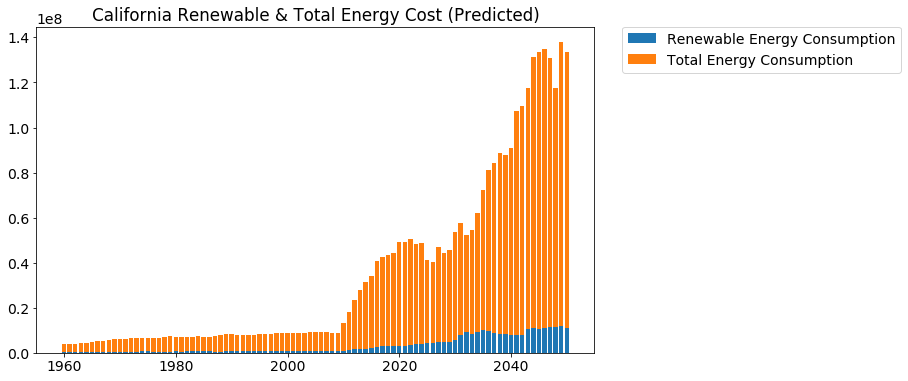

In [15]:
draw_renewable_ratio_bar('CA', 'California Renewable & Total Energy Cost (Predicted)', y)

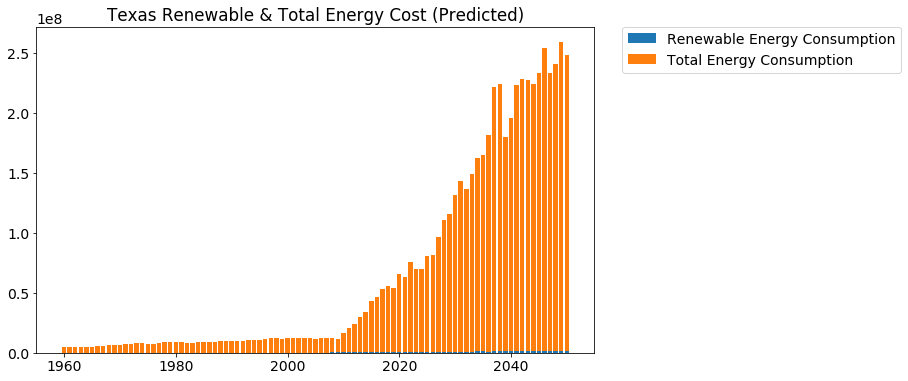

In [16]:
draw_renewable_ratio_bar('TX', 'Texas Renewable & Total Energy Cost (Predicted)', y4)

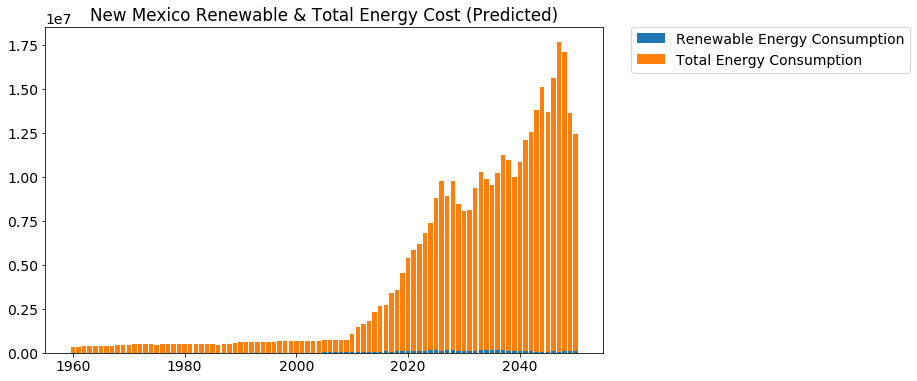

In [17]:
draw_renewable_ratio_bar('NM', 'New Mexico Renewable & Total Energy Cost (Predicted)', y3)

In [20]:
def relu(a):
    b = a
    for i in range(len(a)):
        if a[i] < 0:
            a[i] = 0
    return a

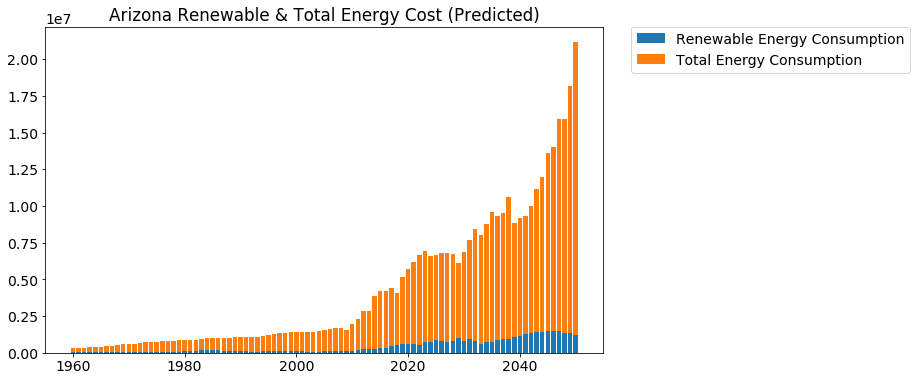

In [48]:
draw_renewable_ratio_bar('AZ', 'Arizona Renewable & Total Energy Cost (Predicted)', y2)

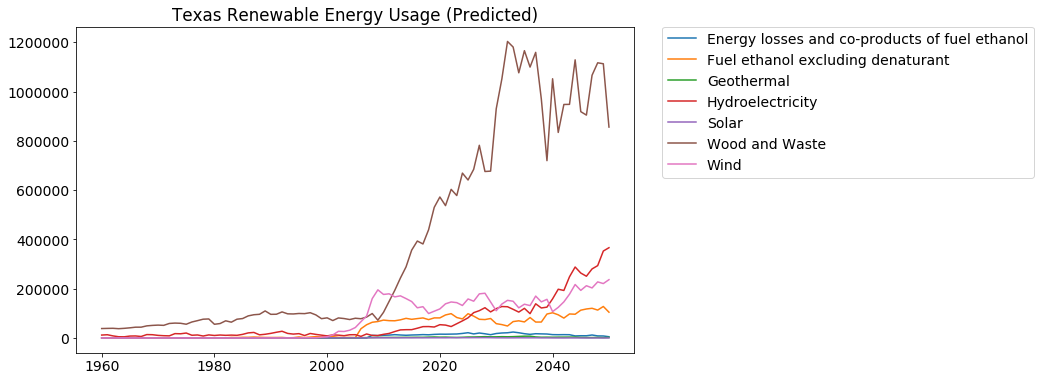

In [42]:
yrs = range(1960, 2051)
inp = y4
emlcb = relu(inp[0])
emtcb = relu(inp[1])
getcb = relu(inp[2])
hytcb = relu(inp[3])
sotcb = relu(inp[4])
wwtcb = relu(inp[5])
wytcb = relu(inp[6])
plt.figure(figsize=(10, 6))
plt.plot(yrs, emlcb, label='Energy losses and co-products of fuel ethanol')
plt.plot(yrs, emtcb, label='Fuel ethanol excluding denaturant')
plt.plot(yrs, getcb, label='Geothermal')
plt.plot(yrs, hytcb, label='Hydroelectricity')
plt.plot(yrs, sotcb, label='Solar')
plt.plot(yrs, wwtcb, label='Wood and Waste')
plt.plot(yrs, wytcb, label='Wind')
plt.title('Texas Renewable Energy Usage (Predicted)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

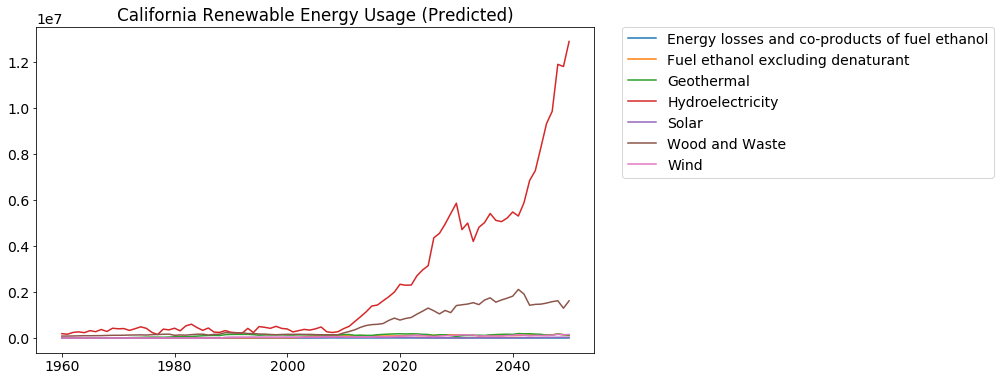

In [32]:
yrs = range(1960, 2051)
inp = y
emlcb = relu(inp[0])
emtcb = relu(inp[1])
getcb = relu(inp[2])
hytcb = relu(inp[3])
sotcb = relu(inp[4])
wwtcb = relu(inp[5])
wytcb = relu(inp[6])
plt.figure(figsize=(10, 6))
plt.plot(yrs, emlcb, label='Energy losses and co-products of fuel ethanol')
plt.plot(yrs, emtcb, label='Fuel ethanol excluding denaturant')
plt.plot(yrs, getcb, label='Geothermal')
plt.plot(yrs, hytcb, label='Hydroelectricity')
plt.plot(yrs, sotcb, label='Solar')
plt.plot(yrs, wwtcb, label='Wood and Waste')
plt.plot(yrs, wytcb, label='Wind')
plt.title('California Renewable Energy Usage (Predicted)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

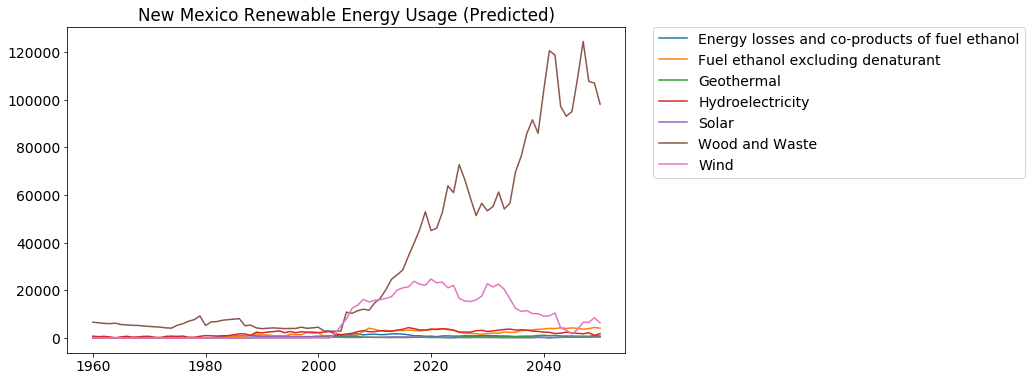

In [39]:
yrs = range(1960, 2051)
inp = y3
emlcb = relu(inp[0])
emtcb = relu(inp[1])
getcb = relu(inp[2])
hytcb = relu(inp[3])
sotcb = relu(inp[4])
wwtcb = relu(inp[5])
wytcb = relu(inp[6])
plt.figure(figsize=(10, 6))
plt.plot(yrs, emlcb, label='Energy losses and co-products of fuel ethanol')
plt.plot(yrs, emtcb, label='Fuel ethanol excluding denaturant')
plt.plot(yrs, getcb, label='Geothermal')
plt.plot(yrs, hytcb, label='Hydroelectricity')
plt.plot(yrs, sotcb, label='Solar')
plt.plot(yrs, wwtcb, label='Wood and Waste')
plt.plot(yrs, wytcb, label='Wind')
plt.title('New Mexico Renewable Energy Usage (Predicted)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

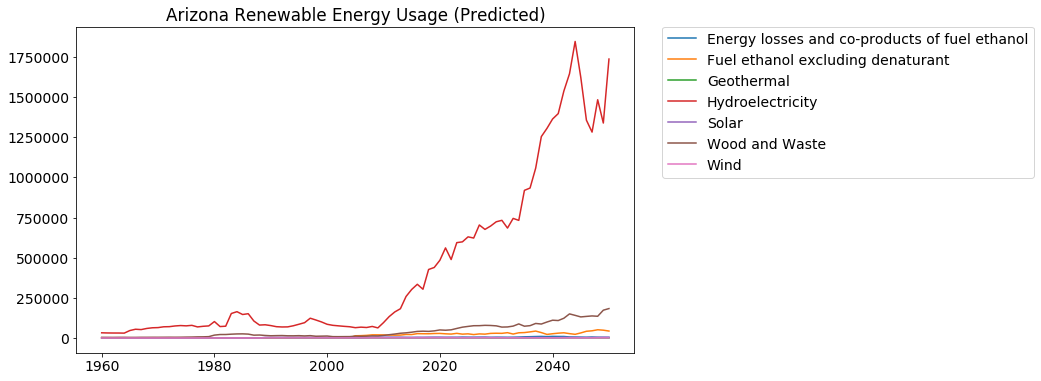

In [46]:
yrs = range(1960, 2051)
inp = y2
emlcb = relu(inp[0])
emtcb = relu(inp[1])
getcb = relu(inp[2])
hytcb = relu(inp[3])
sotcb = relu(inp[4])
wwtcb = relu(inp[5])
wytcb = relu(inp[6])
plt.figure(figsize=(10, 6))
plt.plot(yrs, emlcb, label='Energy losses and co-products of fuel ethanol')
plt.plot(yrs, emtcb, label='Fuel ethanol excluding denaturant')
plt.plot(yrs, getcb, label='Geothermal')
plt.plot(yrs, hytcb, label='Hydroelectricity')
plt.plot(yrs, sotcb, label='Solar')
plt.plot(yrs, wwtcb, label='Wood and Waste')
plt.plot(yrs, wytcb, label='Wind')
plt.title('Arizona Renewable Energy Usage (Predicted)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

[3038.2885180434232, 43128.0412775285, 319.13658226709492, 1736440.5789389848, 4824.2837946934196, 183086.70448730097, 306.29042772567198]


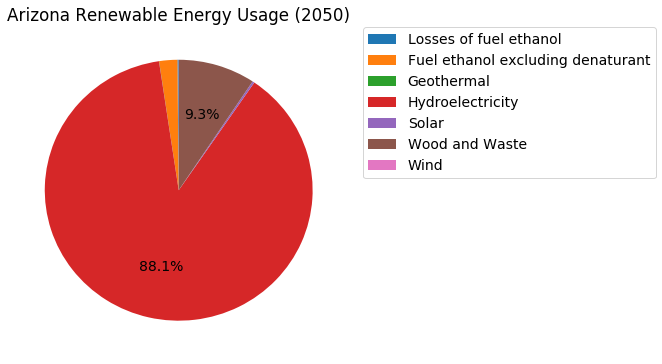

In [47]:
yr = 2050 - 1960
res = [emlcb[yr], emtcb[yr], getcb[yr], hytcb[yr], sotcb[yr], wwtcb[yr], wytcb[yr]]
print(res)
plt.figure(figsize=(6, 6))
plt.pie(res, autopct=lambda pct: ('%3.1f%%' % pct) if pct > 5 else '', labels=None, labeldistance=1.1, shadow=False, startangle=90)
plt.title('Arizona Renewable Energy Usage (%d)' % (yr + 1960))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=['Losses of fuel ethanol', 'Fuel ethanol excluding denaturant', 'Geothermal', 'Hydroelectricity', 'Solar', 'Wood and Waste', 'Wind'])
plt.show()

In [61]:
def lastma(yr1, yr2, y_, n):
    return (y_[n][yr2 - 1960] - y_[n][yr1 - 1960]) / (yr2 - yr1)

In [97]:
# retcb
lastma(2025, 2050, y4, 1)

247.58519864573435